# Logistic Regression

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
from matplotlib import pyplot as plt
import pandas as pd

This project attempts to seperate genuine and forged banknotes using logistic regression. The dataset for this project is taken from *https://archive.ics.uci.edu/ml/datasets/banknote+authentication*. 

The curators of the dataset preprocessed 400 x 400 pixel banknote images using Wavelet Transformation to extract the following features: variance, skewness, curtosis, entropy.  

Since this task requires separating banknotes into two categories, logistic regression will be the best algorithm for this task

In [2]:
'''
link to dataset: https://archive.ics.uci.edu/ml/datasets/banknote+authentication
'''
df = pd.read_csv("data_banknote_authentication.txt")
df

,3.6216,8.6661,-2.8073,-0.44699,0
0,4.54590,8.16740,-2.4586,-1.46210,0
1,3.86600,-2.63830,1.9242,0.10645,0
2,3.45660,9.52280,-4.0112,-3.59440,0
3,0.32924,-4.45520,4.5718,-0.98880,0
4,4.36840,9.67180,-3.9606,-3.16250,0
...,...,...,...,...,...
1366,0.40614,1.34920,-1.4501,-0.55949,1
1367,-1.38870,-4.87730,6.4774,0.34179,1
1368,-3.75030,-13.45860,17.5932,-2.77710,1
1369,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
'''
for preprocessing, we must randomize the dataset so we get an even distribution of labels for training
and testing split
'''

df = df.sample(frac=1)
df

,3.6216,8.6661,-2.8073,-0.44699,0
478,2.0962,2.47690,1.93790,-0.040962,0
533,4.8278,7.75980,-2.44910,-1.221600,0
1029,-1.8439,-8.64750,7.67960,-0.666820,1
187,4.5645,-3.62750,2.86840,0.277140,0
861,-1.2424,-1.71750,-0.52553,-0.210360,1
...,...,...,...,...,...
1370,-2.5419,-0.65804,2.68420,1.195200,1
461,4.9362,7.60460,-2.34290,-0.853020,0
1142,-2.4621,2.76450,-0.62578,-2.857300,1
278,1.9265,7.75570,-0.16823,-3.077100,0


In [4]:
class LogisticRegression(nn.Module):
    def __init__(self, num_features, device = f"cuda:0"):
        super(LogisticRegression, self).__init__()
        '''
        binary classification using Logistic Regression,
        num_features = number of features
        '''
        self.w = nn.Parameter(torch.randn(num_features, 1, device = device), requires_grad=True)   # (n x 1)
        self.b = nn.Parameter(torch.randn(1,1, device = device), requires_grad=True)   # (1 x 1)
        self.n = num_features
    
    def sigmoid(self, a):
        '''
        custom sigmoid function
        '''
        return 1/(1+(torch.exp(-a)))
    
    def forward(self, X):
        '''
        X is (batch_size x n)
        '''
        X = X.T # (n x batch_size)
        A = self.sigmoid(torch.matmul(self.w.T, X) + self.b)  # (1 x batch_size)
        return A.T

In [5]:
def loss_function(X, A, Y):
    '''
    cost function
    
    X = features,
    A = predicted labels,
    Y = actual labels
    '''
    X = X.T
    Y = Y.T
    A = A.T
    n = X.shape[0]
    cost = -1/n * torch.sum(Y*torch.log(A) + (1-Y)*torch.log(1-A))
    X = X.T
    Y = Y.T
    return cost 

def update_grad(X, A, Y, params):
    '''
    calculates/updates the gradient of the cost function

    X = features
    A = predicted labels,
    Y = actual labels
    '''
    w = next(params)
    b = next(params)
    X = X.T
    Y = Y.T
    A = A.T
    n = X.shape[0]
    cost = -torch.sum(Y*torch.log(A) + (1-Y)*torch.log(1-A))  # loss
    w.grad = torch.matmul(X, (A-Y).T) / n  # update gradient of weights, (n x 1)
    b.grad = (torch.sum(A-Y, dim=1).unsqueeze(dim=-1)) / n            # update gradient of bias, (1, 1)
    X = X.T
    Y = Y.T
    return cost 

def gradient_descent(params, learning_rate):
    '''
    performs updates the values of the weights and bias using vanilla gradient descent,
    params = learnable parameters of model
    '''
    with torch.no_grad():
        for p in params:
            p -= learning_rate * p.grad

In [6]:
device = f"cuda:0" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")
mini_batch_size = 64
num_features = df.shape[1] - 1
epochs = 50

vanilla_grad_model = LogisticRegression(num_features)
mini_batch_grad_model = LogisticRegression(num_features)
Adam_model = LogisticRegression(num_features)
RMSprop_model = LogisticRegression(num_features)

data = torch.from_numpy(df.values).float()
train_loader = du.DataLoader(dataset=data[:data.shape[0]*8 // 10],
                             batch_size=df.shape[0],  # batch_size is the length of the entire dataset
                             shuffle=True)
mini_batch_train_loader = du.DataLoader(dataset=data[:data.shape[0]*8 // 10],
                             batch_size=mini_batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=data[data.shape[0]*8//10:],
                             batch_size=df.shape[0],
                             shuffle=True)

Adam_optim = torch.optim.Adam(Adam_model.parameters(), lr=0.1)
RMSprop_optim = torch.optim.RMSprop(RMSprop_model.parameters(), lr=0.1)

# send model over to device
vanilla_grad_model = vanilla_grad_model.to(device)
mini_batch_grad_model = mini_batch_grad_model.to(device)
Adam_model = Adam_model.to(device)
RMSprop_model = RMSprop_model.to(device)
vanilla_grad_model.train() 
mini_batch_grad_model.train()
Adam_model.train() 
RMSprop_model.train()

using device: cuda:0


LogisticRegression()

The two variants of gradient descent I chose to implement are vanilla and minibatch gradient descent

Epoch 1, Training Accuracy: 0.367701, Training Loss = 0.484406
Epoch 2, Training Accuracy: 0.603102, Training Loss = 0.272971
Epoch 3, Training Accuracy: 0.691606, Training Loss = 0.161166
Epoch 4, Training Accuracy: 0.692518, Training Loss = 0.145503
Epoch 5, Training Accuracy: 0.728102, Training Loss = 0.122747
Epoch 6, Training Accuracy: 0.751825, Training Loss = 0.113056
Epoch 7, Training Accuracy: 0.768248, Training Loss = 0.102975
Epoch 8, Training Accuracy: 0.781022, Training Loss = 0.095970
Epoch 9, Training Accuracy: 0.795620, Training Loss = 0.090316
Epoch 10, Training Accuracy: 0.810219, Training Loss = 0.085660
Epoch 11, Training Accuracy: 0.824818, Training Loss = 0.082182
Epoch 12, Training Accuracy: 0.832117, Training Loss = 0.078947
Epoch 13, Training Accuracy: 0.831204, Training Loss = 0.076387
Epoch 14, Training Accuracy: 0.842153, Training Loss = 0.073742
Epoch 15, Training Accuracy: 0.844890, Training Loss = 0.071838
Epoch 16, Training Accuracy: 0.854015, Training L

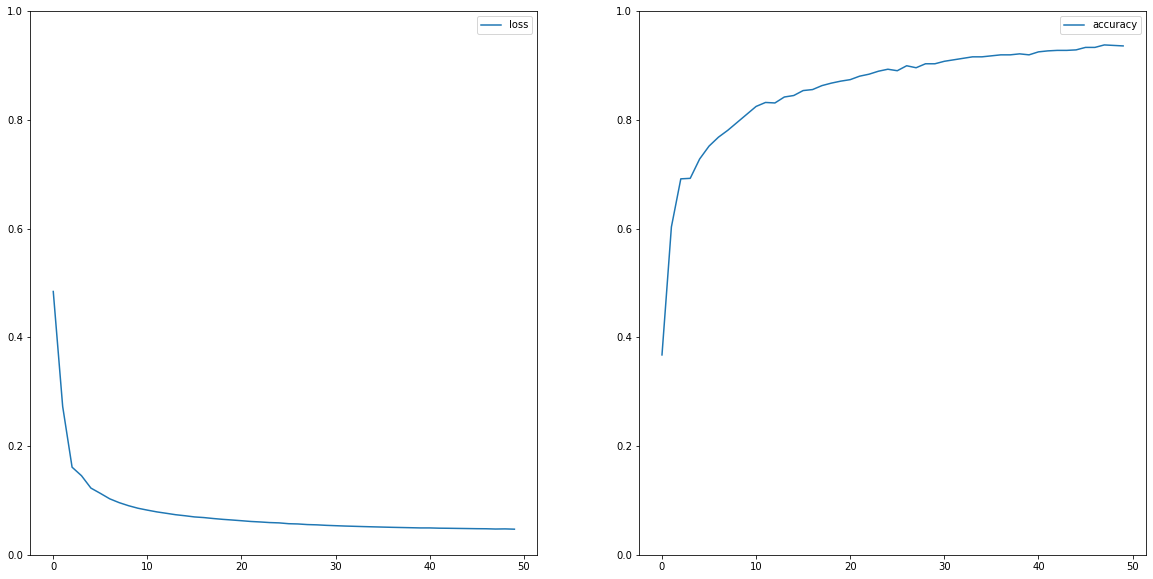

In [7]:
'''
vanilla gradient descent 
'''

loss_list = []
accuracy_list = []
for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    running_accuracy = 0
    for batch_idx, (data) in enumerate(train_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = vanilla_grad_model(features)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, vanilla_grad_model.parameters())
        gradient_descent(vanilla_grad_model.parameters(), learning_rate=0.001)
    loss = running_loss / len(train_loader.dataset)
    loss_list.append(loss.detach().to("cpu"))
    accuracy = correct / len(train_loader.dataset)
    accuracy_list.append(accuracy.detach().to("cpu"))
    print(f"Epoch {epoch}, Training Accuracy: {accuracy:.6f}, Training Loss = {loss:.6f}")

test_correct = 0
test_running_loss = 0
vanilla_grad_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = vanilla_grad_model(features)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].plot(loss_list, label="loss")
ax[0].set_ylim([0,1])
ax[1].plot(accuracy_list, label="accuracy")
ax[1].set_ylim([0,1])
ax[0].legend()
ax[1].legend()

Epoch 1, Training Accuracy: 0.710766, Training Loss = 0.176807
Epoch 2, Training Accuracy: 0.875000, Training Loss = 0.066352
Epoch 3, Training Accuracy: 0.907847, Training Loss = 0.049412
Epoch 4, Training Accuracy: 0.924270, Training Loss = 0.043098
Epoch 5, Training Accuracy: 0.935219, Training Loss = 0.039031
Epoch 6, Training Accuracy: 0.944343, Training Loss = 0.037043
Epoch 7, Training Accuracy: 0.954380, Training Loss = 0.035398
Epoch 8, Training Accuracy: 0.958029, Training Loss = 0.033530
Epoch 9, Training Accuracy: 0.963504, Training Loss = 0.033613
Epoch 10, Training Accuracy: 0.968066, Training Loss = 0.031928
Epoch 11, Training Accuracy: 0.973540, Training Loss = 0.031558
Epoch 12, Training Accuracy: 0.974453, Training Loss = 0.031456
Epoch 13, Training Accuracy: 0.973540, Training Loss = 0.031536
Epoch 14, Training Accuracy: 0.974453, Training Loss = 0.031207
Epoch 15, Training Accuracy: 0.974453, Training Loss = 0.029942
Epoch 16, Training Accuracy: 0.978102, Training L

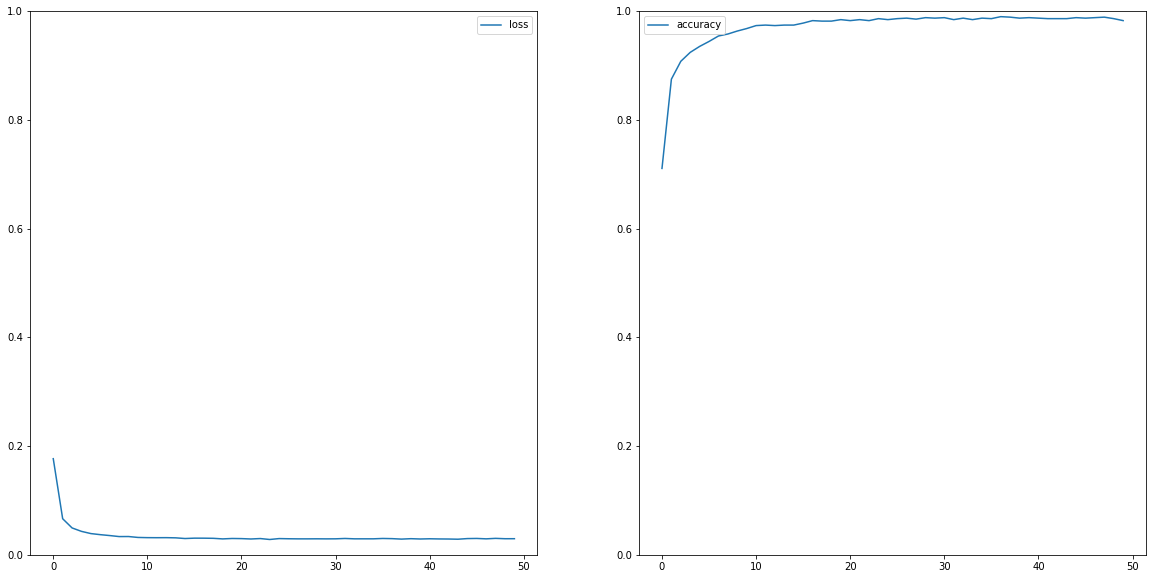

In [8]:
'''
mini batch gradient descent 
'''

loss_list = []
accuracy_list = []
for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    running_accuracy = 0
    for batch_idx, (data) in enumerate(mini_batch_train_loader):  # mini batch size is 64
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = mini_batch_grad_model(features)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, mini_batch_grad_model.parameters())
        gradient_descent(mini_batch_grad_model.parameters(), learning_rate=0.01)
    loss = running_loss / len(mini_batch_train_loader.dataset)
    loss_list.append(loss.detach().to("cpu"))
    accuracy = correct / len(mini_batch_train_loader.dataset)
    accuracy_list.append(accuracy.detach().to("cpu"))
    print(f"Epoch {epoch}, Training Accuracy: {accuracy:.6f}, Training Loss = {loss:.6f}")

test_correct = 0
test_running_loss = 0
mini_batch_grad_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = mini_batch_grad_model(features)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].plot(loss_list, label="loss")
ax[0].set_ylim([0,1])
ax[1].plot(accuracy_list, label="accuracy")
ax[1].set_ylim([0,1])
ax[0].legend()
ax[1].legend()

Using torch.optim package to implement Adam and RMSprop 

Epoch 1, Training Accuracy: 0.437044, Training Loss = 0.495081
Epoch 2, Training Accuracy: 0.830292, Training Loss = 0.107340
Epoch 3, Training Accuracy: 0.909672, Training Loss = 0.050115
Epoch 4, Training Accuracy: 0.973540, Training Loss = 0.029391
Epoch 5, Training Accuracy: 0.988139, Training Loss = 0.023753
Epoch 6, Training Accuracy: 0.993613, Training Loss = 0.023633
Epoch 7, Training Accuracy: 0.989051, Training Loss = 0.022681
Epoch 8, Training Accuracy: 0.989051, Training Loss = 0.023007
Epoch 9, Training Accuracy: 0.991788, Training Loss = 0.023550
Epoch 10, Training Accuracy: 0.992701, Training Loss = 0.022816
Epoch 11, Training Accuracy: 0.990876, Training Loss = 0.023133
Epoch 12, Training Accuracy: 0.990876, Training Loss = 0.023214
Epoch 13, Training Accuracy: 0.988139, Training Loss = 0.023343
Epoch 14, Training Accuracy: 0.989963, Training Loss = 0.022796
Epoch 15, Training Accuracy: 0.989051, Training Loss = 0.024309
Epoch 16, Training Accuracy: 0.989963, Training L

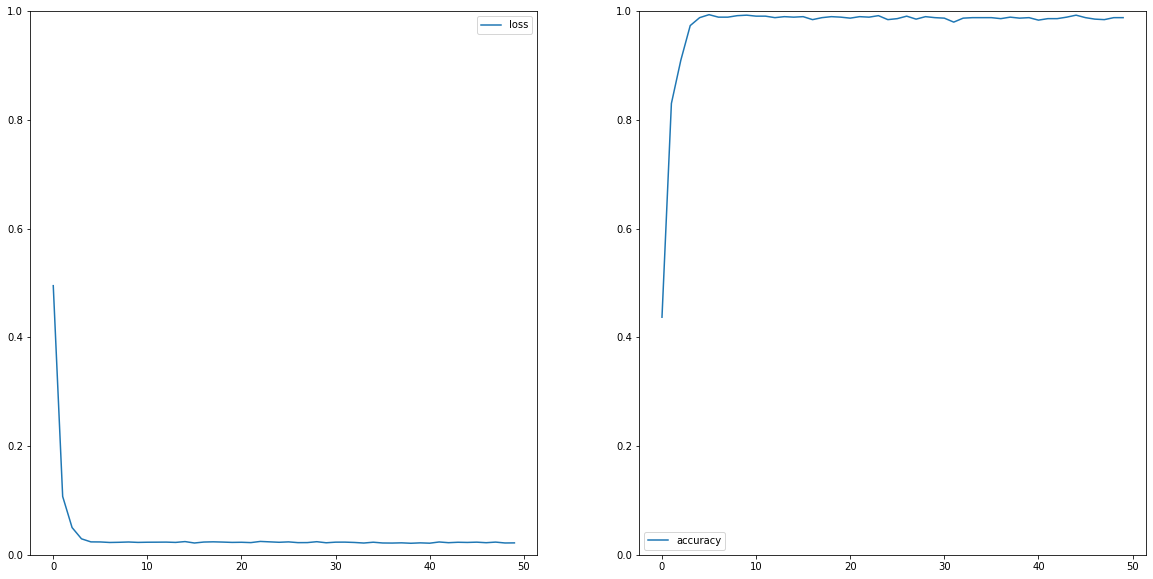

In [9]:
'''
Adam Optimizer
'''

loss_list = []
accuracy_list = []
for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    running_accuracy = 0
    for batch_idx, (data) in enumerate(mini_batch_train_loader):
        Adam_optim.zero_grad()
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = Adam_model(features)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, Adam_model.parameters())
        Adam_optim.step()
    loss = running_loss / len(mini_batch_train_loader.dataset)
    loss_list.append(loss.detach().to("cpu"))
    accuracy = correct / len(mini_batch_train_loader.dataset)
    accuracy_list.append(accuracy.detach().to("cpu"))
    print(f"Epoch {epoch}, Training Accuracy: {accuracy:.6f}, Training Loss = {loss:.6f}")

test_correct = 0
test_running_loss = 0
Adam_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = Adam_model(features)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].plot(loss_list, label="loss")
ax[0].set_ylim([0,1])
ax[1].plot(accuracy_list, label="accuracy")
ax[1].set_ylim([0,1])
ax[0].legend()
ax[1].legend()

Epoch 1, Training Accuracy: 0.918796, Training Loss = nan
Epoch 2, Training Accuracy: 0.976277, Training Loss = 0.024669
Epoch 3, Training Accuracy: 0.981752, Training Loss = 0.019412
Epoch 4, Training Accuracy: 0.982664, Training Loss = 0.019451
Epoch 5, Training Accuracy: 0.982664, Training Loss = 0.018758
Epoch 6, Training Accuracy: 0.983577, Training Loss = 0.016493
Epoch 7, Training Accuracy: 0.974453, Training Loss = 0.019589
Epoch 8, Training Accuracy: 0.979927, Training Loss = 0.016116
Epoch 9, Training Accuracy: 0.980839, Training Loss = 0.017163
Epoch 10, Training Accuracy: 0.984489, Training Loss = 0.016389
Epoch 11, Training Accuracy: 0.983577, Training Loss = 0.015338
Epoch 12, Training Accuracy: 0.977190, Training Loss = 0.016500
Epoch 13, Training Accuracy: 0.985401, Training Loss = 0.013579
Epoch 14, Training Accuracy: 0.981752, Training Loss = 0.016403
Epoch 15, Training Accuracy: 0.981752, Training Loss = 0.013600
Epoch 16, Training Accuracy: 0.989963, Training Loss =

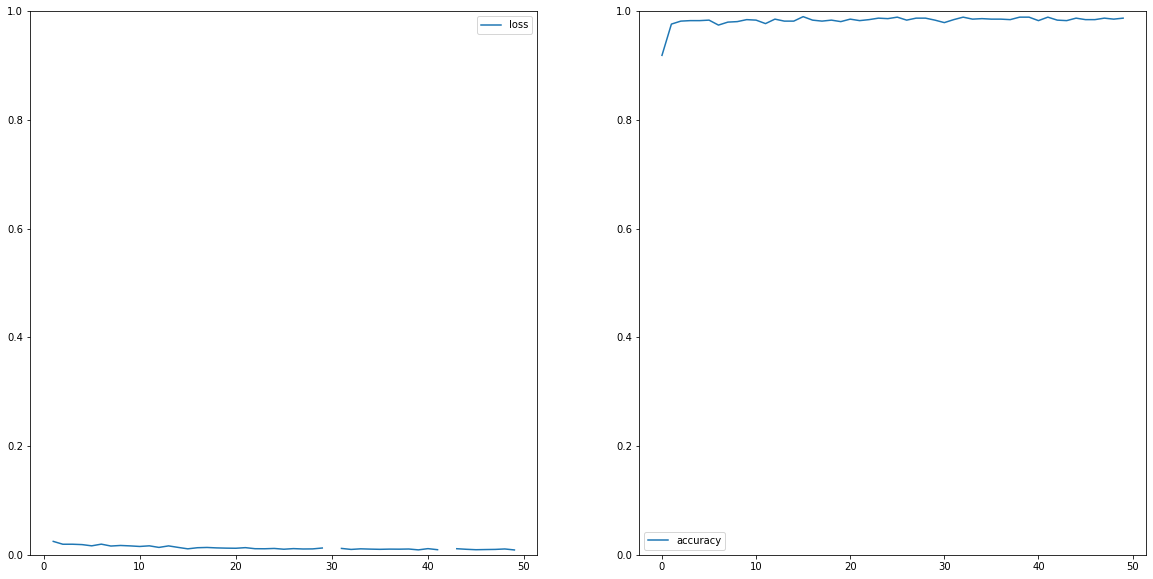

In [10]:
'''
RMSprop Optimizer
'''

loss_list = []
accuracy_list = []
for epoch in range(1, epochs + 1):    
    correct = 0
    running_loss = 0
    running_accuracy = 0
    for batch_idx, (data) in enumerate(mini_batch_train_loader):
        RMSprop_optim.zero_grad()
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = RMSprop_model(features)
        running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        correct += torch.sum(pred == label)
        update_grad(features, pred, label, RMSprop_model.parameters())
        RMSprop_optim.step()
    loss = running_loss / len(mini_batch_train_loader.dataset)
    loss_list.append(loss.detach().to("cpu"))
    accuracy = correct / len(mini_batch_train_loader.dataset)
    accuracy_list.append(accuracy.detach().to("cpu"))
    print(f"Epoch {epoch}, Training Accuracy: {accuracy:.6f}, Training Loss = {loss:.6f}")

test_correct = 0
test_running_loss = 0
RMSprop_model.eval()
with torch.no_grad():
    for batch_idx, (data) in enumerate(test_loader):
        features, label = data[:,:num_features].to(device), data[:,num_features].unsqueeze(1).to(device)
        pred = RMSprop_model(features)
        test_running_loss += loss_function(features, pred, label)
        pred = torch.round(pred)
        test_correct += torch.sum(pred == label)
print(f"Testing Accuracy: {test_correct / len(test_loader.dataset):.6f}, Testing Loss = {test_running_loss / len(test_loader.dataset):.6f}")
fig, ax = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(20)
ax[0].plot(loss_list, label="loss")
ax[0].set_ylim([0,1])
ax[1].plot(accuracy_list, label="accuracy")
ax[1].set_ylim([0,1])
ax[0].legend()
ax[1].legend()

## Analysis

When comparing RMSprop to Adam, we will find that their test accuracies are very similar after 50 epochs. However, when we plot the loss and accuracy per epoch, we will find that RMSprop converges much faster than Adam does. Therefore, RMSprop is the better optimizer for this task

When comparing the accuracy/loss for all the epochs on a graph for gradient descent and the optimizers, we will find that the optimizers converge faster than gradient descent. In addition, I noticed that the optimizers had more stable training, which enabled me to use higher learning rates to train the model. Therefore, using optimizers is the clear choicefore this task.